In [10]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import matplotlib as mpl
from gadds import AreaDetectorImage

# Set up matplotlib for better plots
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['font.size'] = 10
mpl.rcParams['mathtext.default'] = 'regular'


In [11]:
gfrm_files = [
    r"test\20250709_S_MeO_B01_000.gfrm",
    r"test\20250709_S_MeO_B01_001.gfrm"
]


In [12]:
area_detectors = [AreaDetectorImage(gfrm_file) for gfrm_file in gfrm_files]

for area_detector in area_detectors:
    # Display header information
    print("=== GFRM File Header Information ===")
    if hasattr(area_detector.image, 'header'):
        print(f"TITLE: {area_detector.image.header['TITLE'].strip()}")
    else:
        print("No header information available")

    print("=== Processed Parameters ===")
    print(f"Alpha (2θ center): {np.rad2deg(area_detector.alpha):.2f}°")
    print(f"Distance: {area_detector.distance:.2f} cm")
    print(f"Detector center (x, y): {area_detector.centerXY}")
    print(f"Pixel density (x, y): {area_detector.densityXY} pixels/cm")
    print(f"Scale factor: {area_detector.scale}")
    print(f"Offset: {area_detector.offset}")
    print("=== end ===\n")
    print("Converting to 2θ-γ space...")
    area_detector.convert(n_twoth=512, n_gamma=512)
    print(f"Converted image shape: {area_detector.data_converted.shape}\n")

=== GFRM File Header Information ===
TITLE: 20250709_S_MeO
20250709_S_MeO
=== Processed Parameters ===
Alpha (2θ center): 20.00°
Distance: 22.45 cm
Detector center (x, y): (1003.7000122, 1022.0999756)
Pixel density (x, y): (147.0628052, 147.0628052) pixels/cm
Scale factor: 1.0
Offset: 0.0
=== end ===

Converting to 2θ-γ space...
Converted image shape: (512, 512)

=== GFRM File Header Information ===
TITLE: 20250709_S_MeO
20250709_S_MeO
=== Processed Parameters ===
Alpha (2θ center): 30.00°
Distance: 22.45 cm
Detector center (x, y): (1003.7000122, 1022.0999756)
Pixel density (x, y): (147.0628052, 147.0628052) pixels/cm
Scale factor: 1.0
Offset: 0.0
=== end ===

Converting to 2θ-γ space...
Converted image shape: (512, 512)



# GADDS Area Detector Merging with Weight Normalization

This notebook demonstrates merging of two area detectors with different weight normalization approaches for handling overlapping regions.

## Overview

We implement and compare two methods for handling detector overlap regions:

### Method 1: Original Data-Driven Approach
- **Boundary Detection**: Uses interpolated detector data coverage to determine boundaries
- **Weight Assignment**: Weight = 1 for single detector coverage, Weight = 2 for actual overlap
- **Characteristics**: Creates irregular but accurate boundaries based on actual data coverage

### Method 2: Convex Hull Approach  
- **Boundary Detection**: Creates a convex hull around the original overlap region
- **Weight Assignment**: Weight = 1 outside hull, Weight = 2 for all points inside hull
- **Characteristics**: Creates a smooth, geometric boundary that expands the overlap region

## Key Features
- **Common Grid**: Unified coordinate system covering both detectors
- **Proper Normalization**: `Final Data = Raw Data ÷ Weight Grid`
- **Curved Boundaries**: Both methods respect detector geometry
- **Visual Comparison**: Side-by-side analysis of both approaches

In [13]:
# ============================================================================
# METHOD 1: ORIGINAL DATA-DRIVEN WEIGHT GRID
# ============================================================================
print("=== Method 1: Original Data-Driven Weight Grid ===")

# Get coordinate ranges for each detector
detector_ranges = []
for i, area_detector in enumerate(area_detectors):
    twoth_min, twoth_max = area_detector.indexes[1].min(), area_detector.indexes[1].max()
    gamma_min, gamma_max = area_detector.indexes[0].min(), area_detector.indexes[0].max()
    detector_ranges.append((twoth_min, twoth_max, gamma_min, gamma_max))
    print(f"Detector {i}: 2θ = [{twoth_min:.2f}, {twoth_max:.2f}]°, γ = [{gamma_min:.2f}, {gamma_max:.2f}]°")

# Create common grid covering both detectors
all_twoth_min = min(detector_ranges[0][0], detector_ranges[1][0])
all_twoth_max = max(detector_ranges[0][1], detector_ranges[1][1])
all_gamma_min = min(detector_ranges[0][2], detector_ranges[1][2])
all_gamma_max = max(detector_ranges[0][3], detector_ranges[1][3])

# Use finest resolution from both detectors
twoth_step = min(
    area_detectors[0].indexes[1][1] - area_detectors[0].indexes[1][0],
    area_detectors[1].indexes[1][1] - area_detectors[1].indexes[1][0]
)
gamma_step = min(
    area_detectors[0].indexes[0][1] - area_detectors[0].indexes[0][0],
    area_detectors[1].indexes[0][1] - area_detectors[1].indexes[0][0]
)

n_twoth = int((all_twoth_max - all_twoth_min) / twoth_step) + 1
n_gamma = int((all_gamma_max - all_gamma_min) / gamma_step) + 1

common_twoth = np.linspace(all_twoth_min, all_twoth_max, n_twoth)
common_gamma = np.linspace(all_gamma_min, all_gamma_max, n_gamma)

print(f"Common grid: {n_gamma} × {n_twoth} points, resolution: {twoth_step:.4f}° × {gamma_step:.4f}°")

# Initialize arrays
merged_data = np.zeros((n_gamma, n_twoth))
weight_grid = np.zeros((n_gamma, n_twoth))
twoth_mesh, gamma_mesh = np.meshgrid(common_twoth, common_gamma, indexing='xy')

# Process each detector with accurate boundary detection
from scipy.interpolate import RegularGridInterpolator

detector_coverage_masks = []

for i, area_detector in enumerate(area_detectors):
    print(f"Processing detector {i}...")
    
    # Create data interpolator
    interpolator = RegularGridInterpolator(
        (area_detector.indexes[0], area_detector.indexes[1]),
        area_detector.data_converted,
        bounds_error=False, fill_value=0
    )
    interpolated_data = interpolator((gamma_mesh, twoth_mesh))
    
    # Create coverage interpolator for accurate boundaries
    detector_mask = area_detector.data_converted > 0
    coverage_interpolator = RegularGridInterpolator(
        (area_detector.indexes[0], area_detector.indexes[1]),
        detector_mask.astype(float),
        bounds_error=False, fill_value=0, method='linear'
    )
    coverage_values = coverage_interpolator((gamma_mesh, twoth_mesh))
    
    # Determine detector coverage with boundary constraints
    within_bounds = ((np.deg2rad(gamma_mesh) >= area_detector.limits[2]) & 
                     (np.deg2rad(gamma_mesh) <= area_detector.limits[3]) &
                     (np.deg2rad(twoth_mesh) >= area_detector.limits[0]) & 
                     (np.deg2rad(twoth_mesh) <= area_detector.limits[1]))
    
    data_coverage_mask = interpolated_data > 0
    coverage_mask = (coverage_values > 0.1) & within_bounds
    final_coverage_mask = data_coverage_mask | (coverage_mask & (interpolated_data >= 0))
    
    detector_coverage_masks.append(final_coverage_mask)
    
    # Accumulate data and weights
    merged_data[final_coverage_mask] += interpolated_data[final_coverage_mask]
    weight_grid[final_coverage_mask] += 1

# Find overlap region
overlap_mask = detector_coverage_masks[0] & detector_coverage_masks[1]

print(f"Coverage analysis:")
for i, mask in enumerate(detector_coverage_masks):
    print(f"  Detector {i}: {np.sum(mask):,} pixels")
print(f"  Overlap region: {np.sum(overlap_mask):,} pixels")

# Apply normalization
normalized_data = np.divide(merged_data, weight_grid, out=np.zeros_like(merged_data), where=weight_grid!=0)

print(f"✓ Method 1 completed: {np.sum(weight_grid > 1):,} overlap pixels, max weight = {np.max(weight_grid)}")

=== Method 1: Original Data-Driven Weight Grid ===
Detector 0: 2θ = [2.46, 39.97]°, γ = [-171.75, -8.29]°
Detector 1: 2θ = [12.46, 49.09]°, γ = [-143.93, -36.20]°
Common grid: 776 × 651 points, resolution: 0.0717° × 0.2108°
Processing detector 0...
Processing detector 1...
Coverage analysis:
  Detector 0: 180,257 pixels
  Detector 1: 113,314 pixels
  Overlap region: 80,653 pixels
✓ Method 1 completed: 80,653 overlap pixels, max weight = 2.0


In [14]:
# ============================================================================
# METHOD 2: CONVEX HULL WEIGHT GRID
# ============================================================================
print("=== Method 2: Convex Hull Weight Grid ===")

from scipy.spatial import ConvexHull
from matplotlib.path import Path

# Find all points where original weight_grid == 2 (actual overlap region)
overlap_points_indices = np.where(weight_grid == 2)
overlap_gamma_indices = overlap_points_indices[0]  # Row indices (γ)
overlap_twoth_indices = overlap_points_indices[1]  # Column indices (2θ)

# Convert indices to actual coordinates
overlap_gamma_coords = common_gamma[overlap_gamma_indices]
overlap_twoth_coords = common_twoth[overlap_twoth_indices]

print(f"Original overlap region: {len(overlap_gamma_coords):,} points")
print(f"  2θ range: [{np.min(overlap_twoth_coords):.2f}, {np.max(overlap_twoth_coords):.2f}]°")
print(f"  γ range: [{np.min(overlap_gamma_coords):.2f}, {np.max(overlap_gamma_coords):.2f}]°")

if len(overlap_gamma_coords) > 3:  # Need at least 3 points for hull
    
    # Create convex hull around overlap points
    overlap_points_2d = np.column_stack((overlap_twoth_coords, overlap_gamma_coords))
    
    try:
        hull = ConvexHull(overlap_points_2d)
        hull_points = overlap_points_2d[hull.vertices]
        hull_points_closed = np.vstack([hull_points, hull_points[0]])  # Close for plotting
        
        print(f"Convex hull created with {len(hull_points)} vertices")
        
        # Create new weight grid with weight = 2 inside convex hull
        hull_path = Path(hull_points)
        convex_hull_weight_grid = weight_grid.copy()
        
        # Test all grid points for inclusion in hull
        mesh_points = np.column_stack((twoth_mesh.ravel(), gamma_mesh.ravel()))
        inside_hull = hull_path.contains_points(mesh_points)
        inside_hull_2d = inside_hull.reshape(twoth_mesh.shape)
        
        # Set weight = 2 for points inside hull that have detector coverage
        points_with_coverage = convex_hull_weight_grid > 0
        points_in_hull = inside_hull_2d & points_with_coverage
        convex_hull_weight_grid[points_in_hull] = 2
        
        # Apply normalization with new weights
        convex_hull_normalized_data = np.divide(merged_data, convex_hull_weight_grid, 
                                              out=np.zeros_like(merged_data), 
                                              where=convex_hull_weight_grid!=0)
        
        # Calculate statistics
        points_with_weight_two = np.sum(convex_hull_weight_grid == 2)
        points_with_weight_one = np.sum(convex_hull_weight_grid == 1)
        total_points_in_hull = np.sum(points_in_hull)
        
        # Calculate hull area
        hull_area = 0.5 * np.abs(np.dot(hull_points_closed[:-1, 0], hull_points_closed[1:, 1]) - 
                                np.dot(hull_points_closed[1:, 0], hull_points_closed[:-1, 1]))
        
        print(f"Hull statistics:")
        print(f"  Area: {hull_area:.2f} deg²")
        print(f"  Points with weight = 2: {points_with_weight_two:,}")
        print(f"  Points with weight = 1: {points_with_weight_one:,}")
        print(f"  Total points in hull: {total_points_in_hull:,}")
        
        # Calculate expansion
        original_overlap_points = np.sum(weight_grid == 2)
        additional_points = points_with_weight_two - original_overlap_points
        expansion_pct = 100 * additional_points / original_overlap_points if original_overlap_points > 0 else 0
        print(f"  Hull expansion: {additional_points:,} points ({expansion_pct:.1f}% increase)")
        
        hull_success = True
        
    except Exception as e:
        print(f"Error creating convex hull: {e}")
        hull_points_closed = None
        convex_hull_weight_grid = weight_grid.copy()
        convex_hull_normalized_data = normalized_data.copy()
        hull_success = False

else:
    print("Insufficient overlap points for convex hull")
    hull_points_closed = None
    convex_hull_weight_grid = weight_grid.copy()
    convex_hull_normalized_data = normalized_data.copy()
    hull_success = False

print(f"✓ Method 2 completed: Hull expansion method {'successful' if hull_success else 'failed'}")

=== Method 2: Convex Hull Weight Grid ===
Original overlap region: 80,653 points
  2θ range: [13.08, 36.11]°
  γ range: [-124.92, -54.90]°
Convex hull created with 63 vertices
Hull statistics:
  Area: 1295.69 deg²
  Points with weight = 2: 85,624
  Points with weight = 1: 127,294
  Total points in hull: 85,615
  Hull expansion: 4,971 points (6.2% increase)
✓ Method 2 completed: Hull expansion method successful


=== Creating Side-by-Side Comparison ===


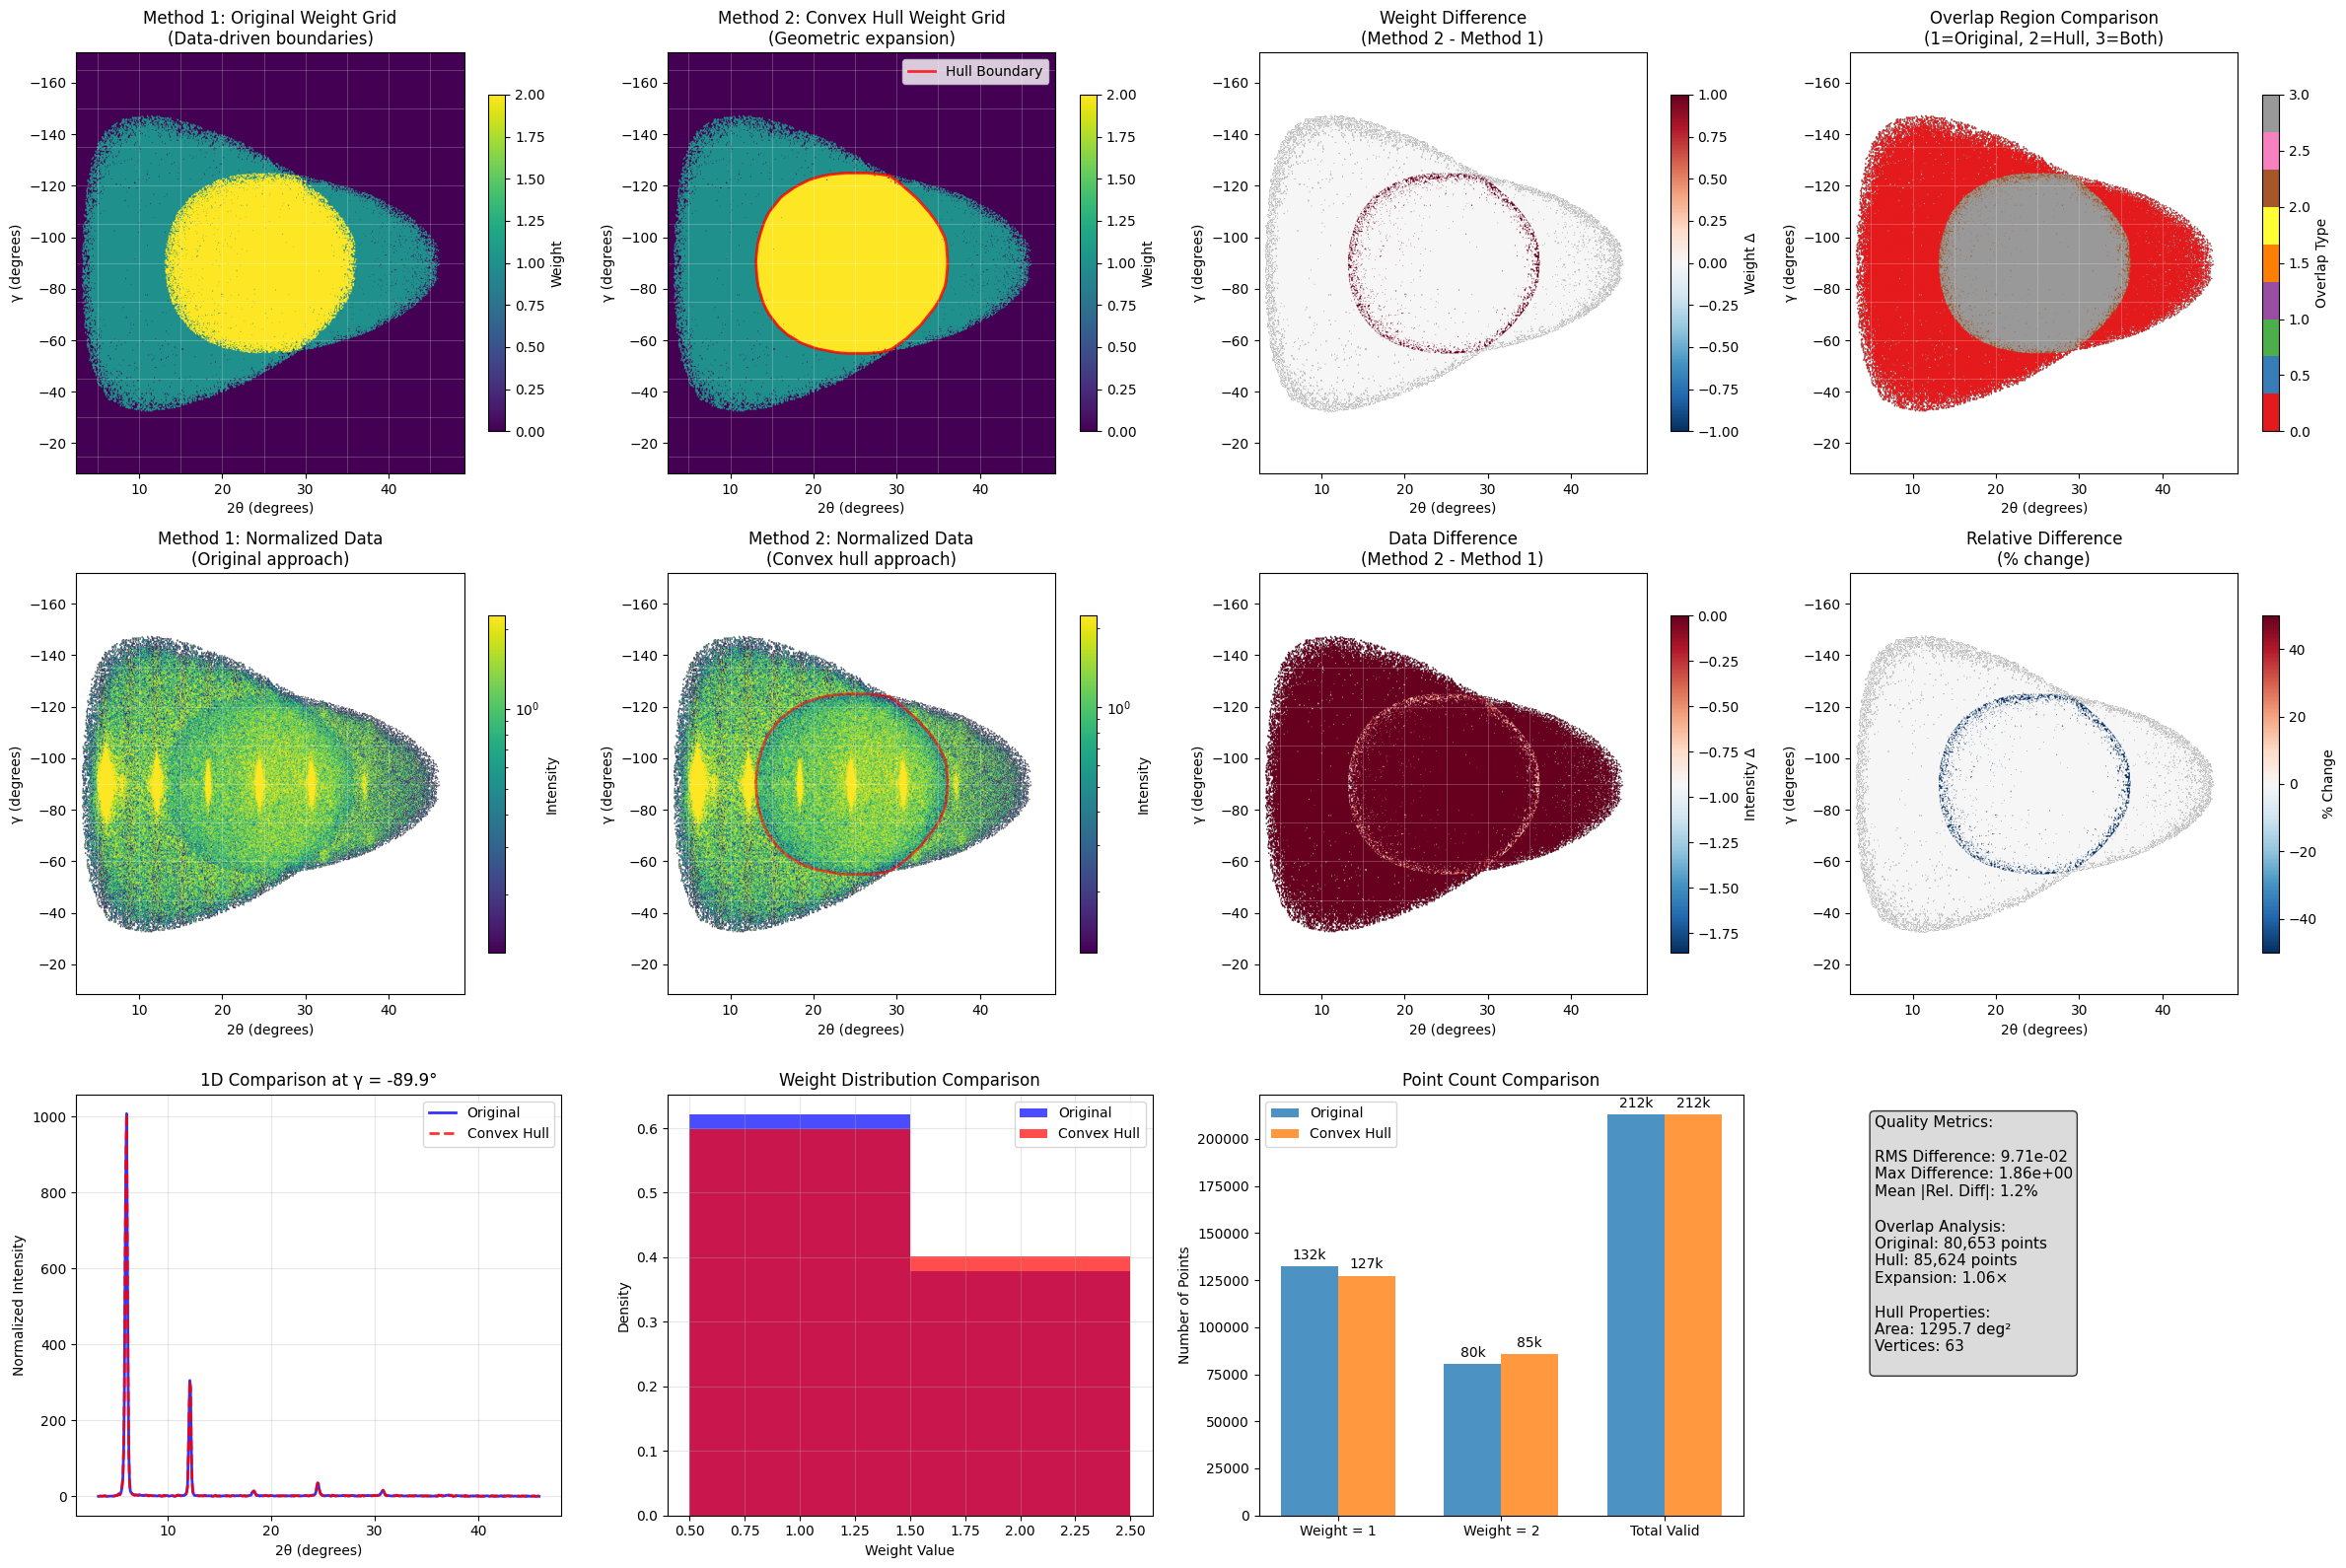

✓ Side-by-side comparison completed!


In [15]:
# ============================================================================
# SIDE-BY-SIDE COMPARISON: ORIGINAL vs CONVEX HULL METHODS
# ============================================================================
print("=== Creating Side-by-Side Comparison ===")

fig = plt.figure(figsize=(24, 16))

# Calculate display extent
extent = [common_twoth.min(), common_twoth.max(), common_gamma.max(), common_gamma.min()]

# ================================
# ROW 1: WEIGHT GRIDS
# ================================

# Original weight grid
ax1 = plt.subplot(3, 4, 1)
im1 = ax1.imshow(weight_grid, cmap='viridis', origin='upper', extent=extent, aspect='auto')
ax1.set_title('Method 1: Original Weight Grid\n(Data-driven boundaries)', fontsize=12)
ax1.set_xlabel('2θ (degrees)')
ax1.set_ylabel('γ (degrees)')
plt.colorbar(im1, ax=ax1, label='Weight', shrink=0.8)

# Convex hull weight grid
ax2 = plt.subplot(3, 4, 2)
im2 = ax2.imshow(convex_hull_weight_grid, cmap='viridis', origin='upper', extent=extent, aspect='auto')
ax2.set_title('Method 2: Convex Hull Weight Grid\n(Geometric expansion)', fontsize=12)
ax2.set_xlabel('2θ (degrees)')
ax2.set_ylabel('γ (degrees)')
if hull_success and hull_points_closed is not None:
    ax2.plot(hull_points_closed[:, 0], hull_points_closed[:, 1], 'r-', 
             linewidth=2, alpha=0.8, label='Hull Boundary')
    ax2.legend(fontsize=10)
plt.colorbar(im2, ax=ax2, label='Weight', shrink=0.8)

# Weight difference
ax3 = plt.subplot(3, 4, 3)
weight_diff = convex_hull_weight_grid - weight_grid
weight_diff[weight_grid == 0] = np.nan
im3 = ax3.imshow(weight_diff, cmap='RdBu_r', origin='upper', extent=extent, aspect='auto', 
                 vmin=-1, vmax=1)
ax3.set_title('Weight Difference\n(Method 2 - Method 1)', fontsize=12)
ax3.set_xlabel('2θ (degrees)')
ax3.set_ylabel('γ (degrees)')
plt.colorbar(im3, ax=ax3, label='Weight Δ', shrink=0.8)

# Overlap regions overlay
ax4 = plt.subplot(3, 4, 4)
overlap_comparison = np.zeros_like(weight_grid)
overlap_comparison[weight_grid == 2] = 1  # Original overlap
overlap_comparison[convex_hull_weight_grid == 2] += 2  # Hull overlap
overlap_comparison[weight_grid == 0] = np.nan
im4 = ax4.imshow(overlap_comparison, cmap='Set1', origin='upper', extent=extent, aspect='auto')
ax4.set_title('Overlap Region Comparison\n(1=Original, 2=Hull, 3=Both)', fontsize=12)
ax4.set_xlabel('2θ (degrees)')
ax4.set_ylabel('γ (degrees)')
plt.colorbar(im4, ax=ax4, label='Overlap Type', shrink=0.8)

# ================================
# ROW 2: NORMALIZED DATA
# ================================

# Original normalized data
ax5 = plt.subplot(3, 4, 5)
normalized_display = normalized_data.copy()
normalized_display[weight_grid == 0] = np.nan

if np.nansum(normalized_display) > 0:
    valid_data = normalized_display[normalized_display > 0]
    if len(valid_data) > 0:
        vmin = np.percentile(valid_data, 5)
        vmax = np.percentile(valid_data, 95)
        if vmin > 0 and vmax > vmin:
            im5 = ax5.imshow(normalized_display, cmap='viridis',
                            norm=colors.LogNorm(vmin=vmin, vmax=vmax),
                            origin='upper', extent=extent, aspect='auto')
        else:
            im5 = ax5.imshow(normalized_display, cmap='viridis',
                            origin='upper', extent=extent, aspect='auto')
    else:
        im5 = ax5.imshow(normalized_display, cmap='viridis',
                        origin='upper', extent=extent, aspect='auto')
else:
    im5 = ax5.imshow(normalized_display, cmap='viridis',
                    origin='upper', extent=extent, aspect='auto')

ax5.set_title('Method 1: Normalized Data\n(Original approach)', fontsize=12)
ax5.set_xlabel('2θ (degrees)')
ax5.set_ylabel('γ (degrees)')
plt.colorbar(im5, ax=ax5, label='Intensity', shrink=0.8)

# Convex hull normalized data
ax6 = plt.subplot(3, 4, 6)
hull_normalized_display = convex_hull_normalized_data.copy()
hull_normalized_display[convex_hull_weight_grid == 0] = np.nan

if np.nansum(hull_normalized_display) > 0:
    valid_hull_data = hull_normalized_display[hull_normalized_display > 0]
    if len(valid_hull_data) > 0:
        vmin_hull = np.percentile(valid_hull_data, 5)
        vmax_hull = np.percentile(valid_hull_data, 95)
        if vmin_hull > 0 and vmax_hull > vmin_hull:
            im6 = ax6.imshow(hull_normalized_display, cmap='viridis',
                            norm=colors.LogNorm(vmin=vmin_hull, vmax=vmax_hull),
                            origin='upper', extent=extent, aspect='auto')
        else:
            im6 = ax6.imshow(hull_normalized_display, cmap='viridis',
                            origin='upper', extent=extent, aspect='auto')
    else:
        im6 = ax6.imshow(hull_normalized_display, cmap='viridis',
                        origin='upper', extent=extent, aspect='auto')
else:
    im6 = ax6.imshow(hull_normalized_display, cmap='viridis',
                    origin='upper', extent=extent, aspect='auto')

ax6.set_title('Method 2: Normalized Data\n(Convex hull approach)', fontsize=12)
ax6.set_xlabel('2θ (degrees)')
ax6.set_ylabel('γ (degrees)')
if hull_success and hull_points_closed is not None:
    ax6.plot(hull_points_closed[:, 0], hull_points_closed[:, 1], 'r-', 
             linewidth=2, alpha=0.6)
plt.colorbar(im6, ax=ax6, label='Intensity', shrink=0.8)

# Data difference
ax7 = plt.subplot(3, 4, 7)
data_difference = convex_hull_normalized_data - normalized_data
data_difference[weight_grid == 0] = np.nan
im7 = ax7.imshow(data_difference, cmap='RdBu_r', origin='upper', extent=extent, aspect='auto')
ax7.set_title('Data Difference\n(Method 2 - Method 1)', fontsize=12)
ax7.set_xlabel('2θ (degrees)')
ax7.set_ylabel('γ (degrees)')
plt.colorbar(im7, ax=ax7, label='Intensity Δ', shrink=0.8)

# Relative difference (%)
ax8 = plt.subplot(3, 4, 8)
relative_diff = np.divide(data_difference, normalized_data, 
                         out=np.zeros_like(data_difference), 
                         where=normalized_data!=0) * 100
relative_diff[weight_grid == 0] = np.nan
im8 = ax8.imshow(relative_diff, cmap='RdBu_r', origin='upper', extent=extent, aspect='auto',
                 vmin=-50, vmax=50)
ax8.set_title('Relative Difference\n(% change)', fontsize=12)
ax8.set_xlabel('2θ (degrees)')
ax8.set_ylabel('γ (degrees)')
plt.colorbar(im8, ax=ax8, label='% Change', shrink=0.8)

# ================================
# ROW 3: ANALYSIS PLOTS
# ================================

# 1D comparison along 2θ (constant γ)
ax9 = plt.subplot(3, 4, 9)
gamma_center_idx = len(common_gamma) // 2
slice_original = normalized_data[gamma_center_idx, :]
slice_hull = convex_hull_normalized_data[gamma_center_idx, :]
slice_weights_original = weight_grid[gamma_center_idx, :]
slice_weights_hull = convex_hull_weight_grid[gamma_center_idx, :]

valid_slice = slice_weights_original > 0
ax9.plot(common_twoth[valid_slice], slice_original[valid_slice], 'b-', 
         linewidth=2, label='Original', alpha=0.8)
ax9.plot(common_twoth[valid_slice], slice_hull[valid_slice], 'r--', 
         linewidth=2, label='Convex Hull', alpha=0.8)
ax9.set_xlabel('2θ (degrees)')
ax9.set_ylabel('Normalized Intensity')
ax9.set_title(f'1D Comparison at γ = {common_gamma[gamma_center_idx]:.1f}°', fontsize=12)
ax9.legend()
ax9.grid(True, alpha=0.3)

# Weight distribution histogram
ax10 = plt.subplot(3, 4, 10)
weights_original = weight_grid[weight_grid > 0]
weights_hull = convex_hull_weight_grid[convex_hull_weight_grid > 0]

ax10.hist(weights_original, bins=np.arange(0.5, 3.5, 1), alpha=0.7, 
          label='Original', color='blue', density=True)
ax10.hist(weights_hull, bins=np.arange(0.5, 3.5, 1), alpha=0.7, 
          label='Convex Hull', color='red', density=True)
ax10.set_xlabel('Weight Value')
ax10.set_ylabel('Density')
ax10.set_title('Weight Distribution Comparison', fontsize=12)
ax10.legend()
ax10.grid(True, alpha=0.3)

# Statistics comparison
ax11 = plt.subplot(3, 4, 11)
stats_data = {
    'Original': [
        np.sum(weight_grid == 1),
        np.sum(weight_grid == 2),
        np.sum(weight_grid > 0)
    ],
    'Convex Hull': [
        np.sum(convex_hull_weight_grid == 1),
        np.sum(convex_hull_weight_grid == 2),
        np.sum(convex_hull_weight_grid > 0)
    ]
}

x = np.arange(3)
width = 0.35
labels = ['Weight = 1', 'Weight = 2', 'Total Valid']

bars1 = ax11.bar(x - width/2, stats_data['Original'], width, label='Original', alpha=0.8)
bars2 = ax11.bar(x + width/2, stats_data['Convex Hull'], width, label='Convex Hull', alpha=0.8)

ax11.set_ylabel('Number of Points')
ax11.set_title('Point Count Comparison', fontsize=12)
ax11.set_xticks(x)
ax11.set_xticklabels(labels)
ax11.legend()

# Add value labels on bars
for bars in [bars1, bars2]:
    for bar in bars:
        height = bar.get_height()
        ax11.annotate(f'{int(height/1000)}k',
                      xy=(bar.get_x() + bar.get_width() / 2, height),
                      xytext=(0, 3),  # 3 points vertical offset
                      textcoords="offset points",
                      ha='center', va='bottom', fontsize=10)

# Quality metrics
ax12 = plt.subplot(3, 4, 12)
ax12.axis('off')

# Calculate quality metrics
if hull_success:
    rms_diff = np.sqrt(np.nanmean(data_difference**2))
    max_diff = np.nanmax(np.abs(data_difference))
    mean_rel_diff = np.nanmean(np.abs(relative_diff))
    
    original_overlap = np.sum(weight_grid == 2)
    hull_overlap = np.sum(convex_hull_weight_grid == 2)
    expansion_factor = hull_overlap / original_overlap if original_overlap > 0 else 0
    
    metrics_text = f"""Quality Metrics:

RMS Difference: {rms_diff:.2e}
Max Difference: {max_diff:.2e}
Mean |Rel. Diff|: {mean_rel_diff:.1f}%

Overlap Analysis:
Original: {original_overlap:,} points
Hull: {hull_overlap:,} points
Expansion: {expansion_factor:.2f}×

Hull Properties:
Area: {hull_area:.1f} deg²
Vertices: {len(hull_points_closed)-1 if hull_points_closed is not None else 0}
"""
else:
    metrics_text = "Convex hull method failed\nNo metrics available"

ax12.text(0.05, 0.95, metrics_text, transform=ax12.transAxes, fontsize=11,
          verticalalignment='top', bbox=dict(boxstyle='round', facecolor='lightgray', alpha=0.8))

# Add grid lines to all image plots
for ax in [ax1, ax2, ax3, ax4, ax5, ax6, ax7, ax8]:
    # 2θ grid lines every 5 degrees
    for twoth in range(int(common_twoth.min()//5)*5, int(common_twoth.max()//5)*5+5, 5):
        if common_twoth.min() <= twoth <= common_twoth.max():
            ax.axvline(x=twoth, color='white', alpha=0.3, linewidth=0.5)
    
    # γ grid lines every 15 degrees  
    for gamma in range(int(common_gamma.min()//15)*15, int(common_gamma.max()//15)*15+15, 15):
        if common_gamma.min() <= gamma <= common_gamma.max():
            ax.axhline(y=gamma, color='white', alpha=0.3, linewidth=0.5)

plt.tight_layout()
plt.show()

print("✓ Side-by-side comparison completed!")